In [16]:
from fastai.basics import *
from fastai.vision import *
from fastai.metrics import *

import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from binary_cmatrix import plot_binary_cm
from binary_cmatrix import binary_cm
from senspec import cm2senspec

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from pandas import DataFrame
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [17]:
data = pd.read_csv("grade_biobank.csv")
images = "/work2/05515/bflynn/frontera/Graded_KL_Images/graded_knee_OA_images"

#### Check that metadata matches directory

In [18]:
i = os.listdir(images)
Files = pd.DataFrame(i, columns=['Filename'])
data = data.merge(Files, how = "inner", on = "Filename")

In [19]:
data

,Deck/Slide,Folder,Filename,Grade
0,1.01,\DICOM\OA_200_jpg\knee1,1.2.840.113619.2.110.210419.20150923171233.2.9...,3
1,1.02,\DICOM\OA_200_jpg\knee1,1.2.840.113619.2.110.210419.20150923173922.2.9...,2
2,1.03,\DICOM\OA_200_jpg\knee1,1.2.840.113619.2.110.210419.20150924134659.2.9...,0
3,1.04,\DICOM\OA_200_jpg\knee1,1.2.840.113619.2.110.210419.20150927084428.1.9...,0
4,1.05,\DICOM\OA_200_jpg\knee1,1.2.840.113619.2.110.210419.20150928094534.2.9...,2
...,...,...,...,...
541,HD3.78,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.212174.20181106114754.1.9...,2
542,HD3.79,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.212174.20181120094219.1.9...,2
543,HD3.80,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.212174.20181128133806.1.9...,2
544,HD3.81,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.212174.20181210165242.1.9...,4


In [20]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(data, test_size = 0.2, random_state=42)
val_df.loc[:,'is_valid']=True
train_df.loc[:,'is_valid']=False
train_df.to_csv("KL_Grade_Training_Data.csv")
val_df.to_csv("KL_Grade_Validation_Data.csv")

In [21]:
train_df

,Deck/Slide,Folder,Filename,Grade,is_valid
93,3.033,\DICOM\OA_200_jpg\knee2,1.2.840.113619.2.110.210419.20180530091657.1.6...,1,False
335,HD1.32,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.210419.20151201140032.1.9...,3,False
412,HD2.29,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.210419.20180724105815.1.6...,4,False
473,HD3.07,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.210419.20181122181900.1.9...,4,False
237,3.035,\DICOM\OA_200_jpg\knee2,1.2.840.113619.2.110.210419.20181120164609.1.6...,2,False
...,...,...,...,...,...
71,1.71,\DICOM\OA_200_jpg\knee2,1.2.840.113619.2.110.210419.20151018084109.2.6...,2,False
106,2.004,\DICOM\OA_200_jpg\knee1,1.2.840.113619.2.110.212174.20190417184957.1.9...,1,False
270,3.066,\DICOM\OA_200_jpg\knee2,1.2.840.113619.2.110.210419.20160808173050.1.6...,2,False
435,HD2.51,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.210419.20170113190930.1.9...,3,False


In [22]:
val_df

,Deck/Slide,Folder,Filename,Grade,is_valid
316,HD1.13,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.210419.20151011131336.2.9...,4,True
77,1.77,\DICOM\NOT_OA_200_jpg\knee1,1.2.840.113619.2.110.210419.20151015113535.2.9...,3,True
360,HD1.58,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.210419.20160112135812.1.6...,4,True
90,1.89,\DICOM\NOT_OA_200_jpg\knee1,1.2.840.113619.2.110.210419.20170924110922.1.9...,2,True
495,HD3.30,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.212038.20170921114548.1.9...,2,True
...,...,...,...,...,...
357,HD1.55,\gonarthrosis_131872_45198\Grades3_4_candidate...,1.2.840.113619.2.110.210419.20151205091023.1.6...,3,True
39,1.4,\DICOM\NOT_OA_200_jpg\knee1,1.2.840.113619.2.110.210419.20151006133134.2.9...,1,True
54,1.54,\DICOM\OA_200_jpg\knee1,1.2.840.113619.2.110.210419.20151006163631.2.9...,3,True
155,2.052,\DICOM\OA_200_jpg\knee1,1.2.840.113619.2.110.212038.20171122120316.1.9...,2,True


In [23]:
image_df = pd.concat([train_df, val_df])

In [24]:
tfms = get_transforms()
size = 224
bs = 62

data = (ImageList.from_df(image_df, path=images, cols="Filename")
              .split_from_df(col="is_valid")
              .label_from_df(cols="Grade")
              .transform(tfms, size=size).databunch(bs=bs, num_workers=4).normalize(imagenet_stats))

In [25]:
data

ImageDataBunch;

Train: LabelList (436 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,3,4,4,2
Path: /work2/05515/bflynn/frontera/Graded_KL_Images/graded_knee_OA_images;

Valid: LabelList (110 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
4,3,4,2,2
Path: /work2/05515/bflynn/frontera/Graded_KL_Images/graded_knee_OA_images;

Test: None

In [26]:
# need to figure out how to calculate this

class MultiLabelFbeta(Callback):
    # Computes the fbeta score for multilabel classification
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
    _order = -20 
    def __init__(self, beta=2, eps=1e-15, thresh=0.3, sigmoid=True, average="micro"):
        self.eps,self.thresh,self.sigmoid,self.average,self.beta = eps,thresh,sigmoid,average,beta

    def on_epoch_begin(self, **kwargs):
        self.tp,self.total_pred,self.total_targ = 0,0,0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        pred, targ = ((last_output.sigmoid() if self.sigmoid else last_output) > self.thresh).byte(), last_target.byte()
        m = pred*targ
        self.tp += m.sum(0).float()
        self.total_pred += pred.sum(0).float()
        self.total_targ += targ.sum(0).float()
    
    def fbeta_score(self, precision, recall):
        beta2 = self.beta**2
        return (1 + beta2)*(precision*recall)/((beta2*precision + recall) + self.eps)

    def on_epoch_end(self, last_metrics, **kwargs):
        self.total_pred += self.eps
        self.total_targ += self.eps
        if self.average == "micro":
            precision, recall = self.tp.sum() / self.total_pred.sum(), self.tp.sum() / self.total_targ.sum()
            res = self.fbeta_score(precision, recall)
        elif self.average == "macro":
            res = self.fbeta_score((self.tp / self.total_pred), (self.tp / self.total_targ)).mean()
        elif self.average == "weighted":
            scores = self.fbeta_score((self.tp / self.total_pred), (self.tp / self.total_targ))
            res = (scores*self.total_targ).sum() / self.total_targ.sum()
        elif self.average == "none":
            res = listify(self.fbeta_score((self.tp / self.total_pred), (self.tp / self.total_targ)))
        else:
            raise Exception("Choose one of the average types: [micro, macro, weighted, none]")
        
        return add_metrics(last_metrics, res)

# Initial - No Changes Made

In [31]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
learn.model_dir="./KL_Models"

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-04
Min loss divided by 10: 1.00E-02


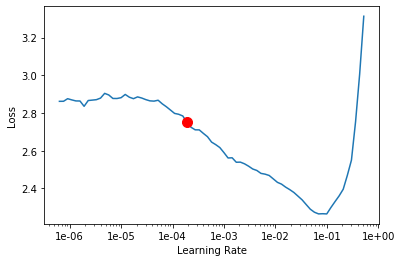

In [32]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [33]:
learn.fit_one_cycle(24, slice(2e-4, 2e-3))

epoch,train_loss,valid_loss,error_rate,time
0,2.835111,1.965150,0.790909,00:06
1,2.643560,1.939542,0.745455,00:06
2,2.425522,1.961841,0.700000,00:06
3,2.296415,1.830258,0.572727,00:06
4,2.194525,2.269853,0.645455,00:06
5,2.129623,1.988872,0.581818,00:06
6,2.022593,1.980026,0.645455,00:06
7,1.947308,1.768049,0.590909,00:06
8,1.850928,1.741880,0.572727,00:07
9,1.758601,1.727392,0.572727,00:07


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 5.75E-07


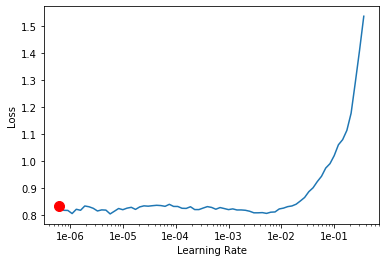

In [34]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [35]:
learn.save('KL_1')

In [36]:
learn.fit_one_cycle(20, slice(2e-6, 1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.840927,1.200213,0.490909,00:07
1,0.826976,1.199331,0.481818,00:06
2,0.831432,1.183334,0.481818,00:07
3,0.818921,1.203171,0.490909,00:06
4,0.817230,1.208660,0.490909,00:06
5,0.841121,1.197816,0.490909,00:07
6,0.839000,1.192513,0.500000,00:06
7,0.849235,1.193333,0.490909,00:06
8,0.850583,1.196143,0.490909,00:06
9,0.847375,1.209528,0.481818,00:06


In [37]:
learn.save('KL_2')

In [38]:
learn.unfreeze()

In [39]:
learn.fit_one_cycle(20, slice(2e-6//400, 1e-5//100))

epoch,train_loss,valid_loss,error_rate,time
0,0.802031,1.195891,0.500000,00:07
1,0.797808,1.205722,0.490909,00:07
2,0.816777,1.185429,0.481818,00:07
3,0.809137,1.195683,0.490909,00:07
4,0.814662,1.196373,0.490909,00:07
5,0.812390,1.184374,0.490909,00:07
6,0.797212,1.178254,0.472727,00:07
7,0.797664,1.185882,0.472727,00:07
8,0.811319,1.187799,0.472727,00:07
9,0.810010,1.194409,0.490909,00:07


In [40]:
learn.save('KL_3')

In [41]:
preds, y = learn.get_preds()

In [46]:
interp = ClassificationInterpretation.from_learner(learn)

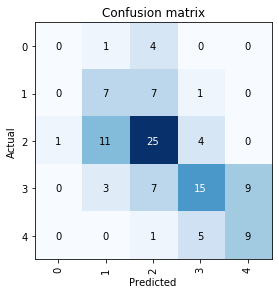

In [47]:
interp.plot_confusion_matrix()

In [61]:
k1 = 7 / (8 + 7)
k2 = 25 / (1+11+4+25)
k3 = 15 / (3+7+9+15)
k4 = 9 / (5+1+9)

In [62]:
print(k1, k2, k3, k4)

0.4666666666666667 0.6097560975609756 0.4411764705882353 0.6
